In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix




In [2]:
# 定义数据目录和子目录（每个子目录对应一个类别）
data_dir = 'D:/tester' 
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
# 创建目标目录
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
# 定义类别列表
classes = ['cataract', 'normal', 'surgery']  
num_classes = len(classes)
print(classes)
# 定义类别到索引的映射
label_to_index = {class_name: i for i, class_name in enumerate(classes)}

['cataract', 'normal', 'surgery']


In [3]:
# 构建包含所有数据信息的列表（图片名与对应label）
all_data_info = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    for img in images:
        all_data_info.append((img, class_name))

# 获取所有图片名和对应label
images, labels = zip(*all_data_info)

In [4]:
# 按比例划分数据集
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)


In [5]:
# 划分训练集
for img, label in zip(train_images, train_labels):
    src = os.path.join(data_dir, label, img)
    dst = os.path.join(train_dir, label, img)
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    shutil.copy(src, dst)

# 划分验证集
for img, label in zip(validation_images, validation_labels):
    src = os.path.join(data_dir, label, img)
    dst = os.path.join(validation_dir, label, img)
    os.makedirs(os.path.join(validation_dir, label), exist_ok=True)
    shutil.copy(src, dst)

# 划分测试集
for img, label in zip(test_images, test_labels):
    src = os.path.join(data_dir, label, img)
    dst = os.path.join(test_dir, label, img)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    shutil.copy(src, dst)

In [6]:
# 加载图像并进行预处理
def load_and_preprocess_data(data_dir, classes, target_size=(256, 256)):
    all_images = []
    all_labels = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        for img in images:
            img_path = os.path.join(class_dir, img)
            img = image.load_img(img_path, target_size=target_size)
            img = image.img_to_array(img)
            img /= 255.0 
            all_images.append(img)
            all_labels.append(class_name)

    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # 独热编码标签
    label_to_index = {class_name: i for i, class_name in enumerate(classes)}
    all_labels = np.array([label_to_index[label] for label in all_labels])
    all_labels = to_categorical(all_labels, num_classes=len(classes))

    return all_images, all_labels

# 重新加载并预处理数据
train_images, train_labels = load_and_preprocess_data(train_dir, classes)
validation_images, validation_labels = load_and_preprocess_data(validation_dir, classes)
test_images, test_labels = load_and_preprocess_data(test_dir, classes)


In [7]:
# 建立CNN模型
input_shape = (256, 256, 3)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(), 
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(len(classes), activation='softmax')  
])

# 设置学习率
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# 编译模型
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0


预测中 ...
1/1 [==============================] - 0s 232ms/step


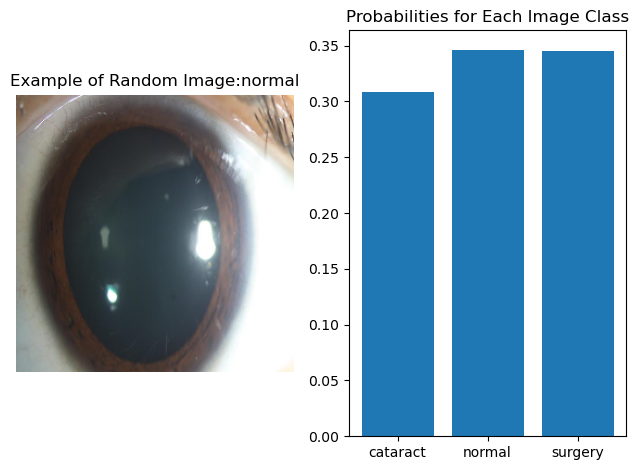

In [8]:
# 从测试集随机选择一张图片
random_index = random.randint(0, len(test_images) - 1)
random_image = test_images[random_index]

# 获取真实类别的索引
true_class_index = np.argmax(test_labels[random_index])

# 绘出图表的预测结果
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Example of Random Image:" + str(classes[true_class_index]))
plt.imshow(random_image)
plt.axis("off")

# 预测结果的概率
print("\n预测中 ...")
probs = model.predict(random_image.reshape(1, 256, 256, 3), batch_size=1)
plt.subplot(1, 2, 2)
plt.title("Probabilities for Each Image Class")
plt.bar(np.arange(len(classes)), probs.reshape(len(classes)), align="center")
plt.xticks(np.arange(len(classes)), classes)
plt.tight_layout()
plt.show()

In [9]:
# 定义训练参数
batch_size = 32
epochs = 20

# 训练模型（没有数据增强）
history_no_augmentation = model.fit(
    train_images, train_labels,  # 使用未经数据增强的数据
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(validation_images, validation_labels)
)



Epoch 1/20
67/67 [==============================] - 76s 1s/step - loss: 0.9806 - accuracy: 0.4613 - val_loss: 0.8376 - val_accuracy: 0.5783
Epoch 2/20
67/67 [==============================] - 73s 1s/step - loss: 0.7584 - accuracy: 0.5882 - val_loss: 0.6999 - val_accuracy: 0.6848
Epoch 3/20
67/67 [==============================] - 73s 1s/step - loss: 0.6431 - accuracy: 0.6600 - val_loss: 0.6263 - val_accuracy: 0.6870
Epoch 4/20
67/67 [==============================] - 74s 1s/step - loss: 0.5873 - accuracy: 0.6978 - val_loss: 0.5613 - val_accuracy: 0.7652
Epoch 5/20
67/67 [==============================] - 72s 1s/step - loss: 0.5405 - accuracy: 0.7528 - val_loss: 0.4892 - val_accuracy: 0.8000
Epoch 6/20
67/67 [==============================] - 76s 1s/step - loss: 0.4999 - accuracy: 0.7822 - val_loss: 0.4501 - val_accuracy: 0.7978
Epoch 7/20
67/67 [==============================] - 75s 1s/step - loss: 0.4673 - accuracy: 0.7962 - val_loss: 0.4451 - val_accuracy: 0.7913
Epoch 8/20
67/67 [==

In [10]:
# 创建经过数据增强的数据生成器
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow(train_images, train_labels, batch_size=batch_size)

# 训练模型（经过数据增强）
history_with_augmentation = model.fit(
    train_generator_augmented,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(validation_images, validation_labels)
)


Epoch 1/20
67/67 [==============================] - 77s 1s/step - loss: 0.2778 - accuracy: 0.9025 - val_loss: 0.3269 - val_accuracy: 0.8696
Epoch 2/20
67/67 [==============================] - 79s 1s/step - loss: 0.2610 - accuracy: 0.9058 - val_loss: 0.2205 - val_accuracy: 0.9109
Epoch 3/20
67/67 [==============================] - 75s 1s/step - loss: 0.3127 - accuracy: 0.8825 - val_loss: 0.1834 - val_accuracy: 0.9500
Epoch 4/20
67/67 [==============================] - 75s 1s/step - loss: 0.2588 - accuracy: 0.9118 - val_loss: 0.1491 - val_accuracy: 0.9652
Epoch 5/20
67/67 [==============================] - 78s 1s/step - loss: 0.2909 - accuracy: 0.8946 - val_loss: 0.1741 - val_accuracy: 0.9587
Epoch 6/20
67/67 [==============================] - 85s 1s/step - loss: 0.2345 - accuracy: 0.9282 - val_loss: 0.2006 - val_accuracy: 0.9435
Epoch 7/20
67/67 [==============================] - 85s 1s/step - loss: 0.2415 - accuracy: 0.9160 - val_loss: 0.1540 - val_accuracy: 0.9609
Epoch 8/20
67/67 [==

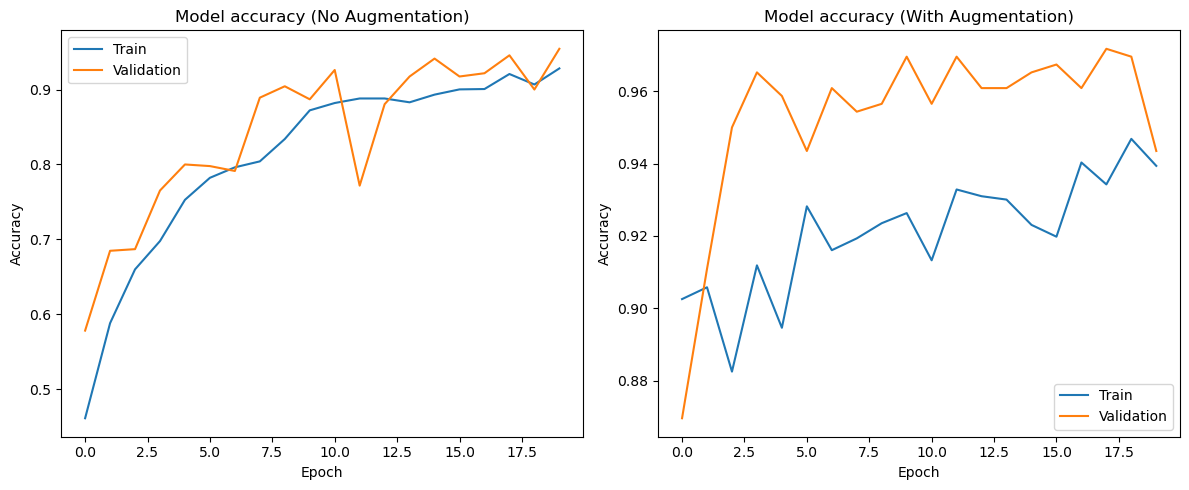

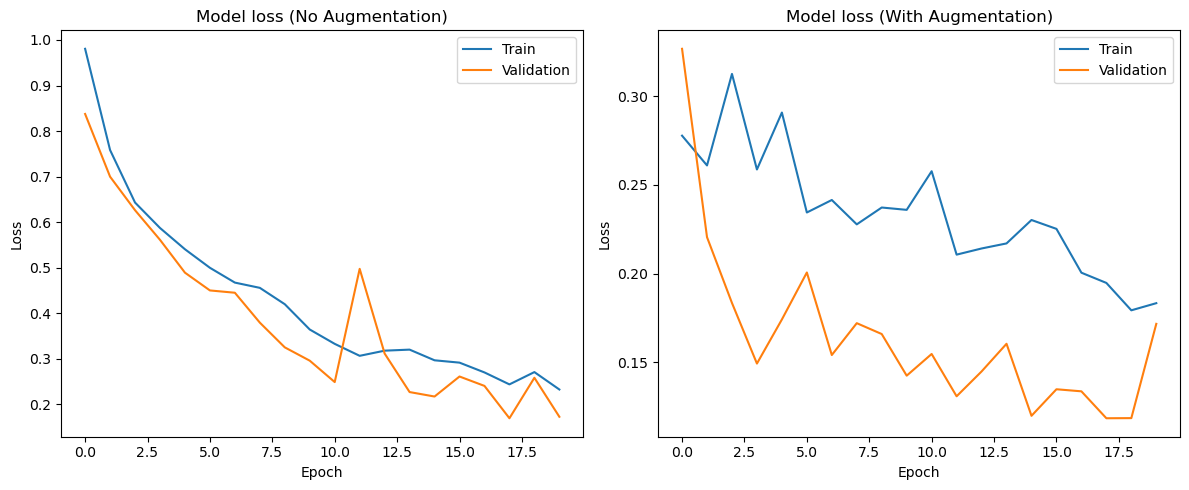

In [11]:
# 训练过程可视化

# 绘制训练 & 验证的准确率值
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_no_augmentation.history['accuracy'], label='Train')
plt.plot(history_no_augmentation.history['val_accuracy'], label='Validation')
plt.title('Model accuracy (No Augmentation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_with_augmentation.history['accuracy'], label='Train')
plt.plot(history_with_augmentation.history['val_accuracy'], label='Validation')
plt.title('Model accuracy (With Augmentation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 绘制训练 & 验证的损失值
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_no_augmentation.history['loss'], label='Train')
plt.plot(history_no_augmentation.history['val_loss'], label='Validation')
plt.title('Model loss (No Augmentation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_with_augmentation.history['loss'], label='Train')
plt.plot(history_with_augmentation.history['val_loss'], label='Validation')
plt.title('Model loss (With Augmentation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
print("\n在训练集上，模型评估中 ...")
train_loss, train_accuracy = model.evaluate(train_generator_augmented)
print("训练数据集的准确度 = {:.2f}".format(train_accuracy))

print("\n在测试集上，模型评估中 ...")
test_loss, test_accuracy = model.evaluate(validation_images, validation_labels)
print("测试数据集的准确度 = {:.2f}".format(test_accuracy))


在训练集上，模型评估中 ...
67/67 [==============================] - 34s 500ms/step - loss: 0.1802 - accuracy: 0.9403
训练数据集的准确度 = 0.94

在测试集上，模型评估中 ...
15/15 [==============================] - 3s 207ms/step - loss: 0.1716 - accuracy: 0.9435
测试数据集的准确度 = 0.94



预测中 ...
15/15 [==============================] - 3s 195ms/step


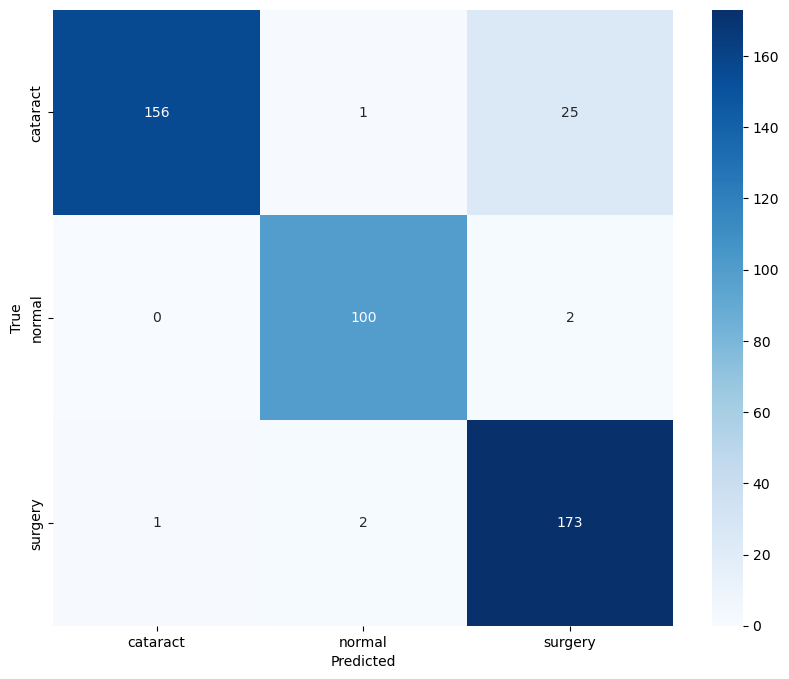

In [13]:
# 首先，对测试集进行预测
print("\n预测中 ...")
predictions = model.predict(test_images)

# 获取预测类别
predicted_classes = np.argmax(predictions, axis=1)

# 将 test_labels 转换为对应的类别名称
true_labels = [classes[np.argmax(label)] for label in test_labels]

# 将类别名称转换为对应的索引
true_classes = np.array([label_to_index[label] for label in true_labels])

# 计算混淆矩阵
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# 显示混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


预测中 ...
1/1 [==============================] - 0s 31ms/step


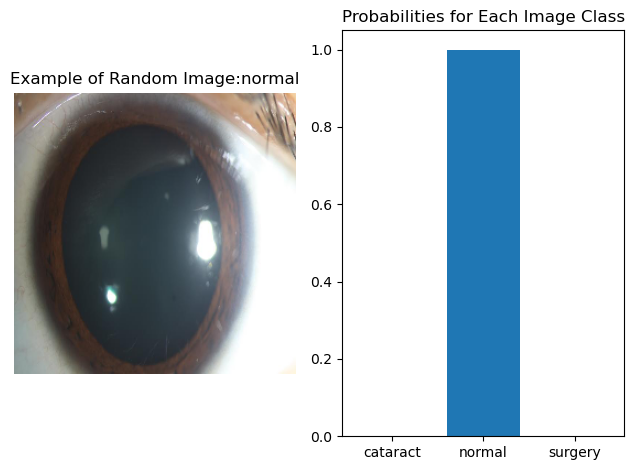

In [14]:
# 绘出图表的预测结果
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Example of Random Image:" + str(classes[true_class_index]))
plt.imshow(random_image)
plt.axis("off")

# 预测结果的概率
print("\n预测中 ...")
probs = model.predict(random_image.reshape(1, 256, 256, 3), batch_size=1)
plt.subplot(1, 2, 2)
plt.title("Probabilities for Each Image Class")
plt.bar(np.arange(len(classes)), probs.reshape(len(classes)), align="center")
plt.xticks(np.arange(len(classes)), classes)
plt.tight_layout()
plt.show()


In [16]:
model.save('D:/tester/model.keras')
